**INSTALLS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
setUser = 'Arian'
%cd /content/drive/MyDrive/GT/ML Team Project

/content/drive/.shortcut-targets-by-id/1J4fu7fH7MuRzcUS_y9yU_1iMrJSkUpbS/ML Team Project


In [3]:
!pip install -q -U tensorflow_decision_forests
!pip install -q -U dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 907.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from dtreeviz.utils import extract_params_from_pipeline
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import export_graphviz
import graphviz
import dtreeviz
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

# avoid "Arial font not found" warnings
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

**HELPER FUNCTIONS**

Function 1: Cleans Data based off of Z-score [working]

In [5]:
# This functions removes all rows from the DataFrame df whose feature value has z-score above 3 or below -3
def remove_outliers_Z_score(df: pd.DataFrame, feature: str):
    z_scores = np.abs(stats.zscore(df[feature]))
    too_high_indices =  np.where(z_scores > 3)[0]
    too_low_indices = np.where(z_scores < -3)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 2: Cleans Data based off of IQR [not working]

In [6]:
# This function removes all rows from the DataFrame df whose feature value is above Q3 + 1.5 * IQR or below Q1 - 1.5 * IQR
# UPDATE: This is giving me issues. Probably better to use Z-score to remove outliers for this dataset
def remove_outliers_IQR(df: pd.DataFrame, feature: str):
    Q1 = np.percentile(df[feature], 25, method = 'midpoint')
    Q3 = np.percentile(df[feature], 75, method = 'midpoint')
    IQR = Q3 - Q1
    too_high_indices = np.where(df[feature] >= Q3 + 1.5 * IQR)[0]
    too_low_indices = np.where(df[feature] <= Q1 - 1.5 * IQR)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 3: Splits pandas DataFrame into training set and testing set

In [7]:
# This function splits a pandas DataFrame into a training set and a test set, specificed by the train_ratio.
def split_dataset(df: pd.DataFrame, train_ratio: float):
  train_indices = np.random.rand(len(df)) < train_ratio
  return df[train_indices], df[~train_indices]

**LOAD DATA**

In [8]:
if setUser == 'Arian':
  property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/GT/ML Team Project/Datasets/kaggle-rental-properties/property_and_user_activity.csv")
elif setUser == 'Sean':
  property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Datasets/kaggle-rental-properties/property_and_user_activity.csv")

<ipython-input-8-673c1603639b>:2: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.


**VISUALIZE DATA**

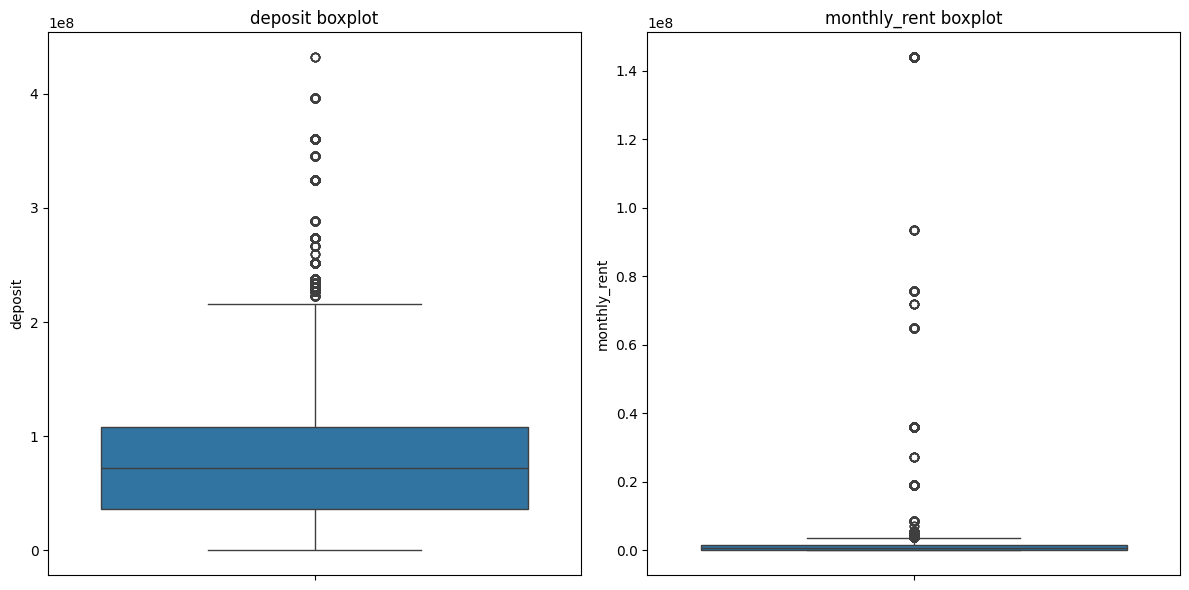

In [9]:
# Visualize the data- this will be helpful in removing outliers later

plt.figure(figsize=(12, 6))

# First Boxplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.boxplot(property_and_user_activity_df['deposit'])
plt.title('deposit boxplot')

# Second Boxplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.boxplot(property_and_user_activity_df['monthly_rent'])
plt.title('monthly_rent boxplot')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()




**CLEAN AND PERFORM RECURSIVE FEATURE ELIMINATION**

-----STARTING-----



<ipython-input-10-051876bc1410>:36: DtypeWarning: Columns (6,9) have mixed types. Specify dtype option on import or set low_memory=False.


Optimal number of features : 4


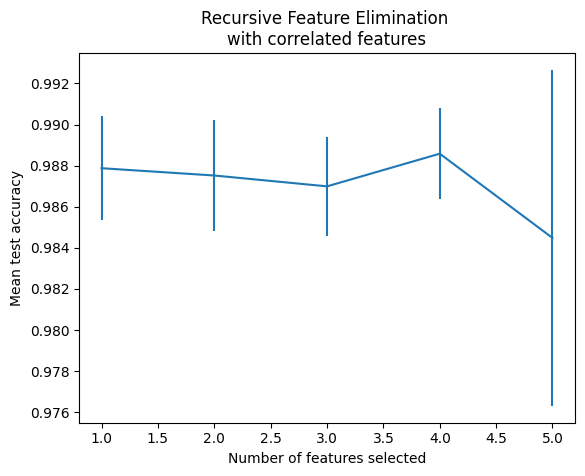


-----FINISHED-----


In [10]:
print("-----STARTING-----\n")

######################################
########### Clean the data ###########
######################################

# Convert text to numbers via one-hot encoding. Then we can handle missing data
# Clean the data
property_and_user_activity_df = property_and_user_activity_df.fillna(property_and_user_activity_df.mode().iloc[0])

# Encode categorical variables
encoder = OneHotEncoder()

# Encode event_type to 1 if it gives reasonable indication that the user would like to rent the house.
property_and_user_activity_df['event_type_num'] = property_and_user_activity_df['event_type'].map(lambda x: 1 if x in ['deal-success', 'meeting-success', 'visit-success', 'visit-new'] else 0)

# Encode categorical variables

property_and_user_activity_df['has_elevator'] = property_and_user_activity_df['has_elevator'].astype('category')
property_and_user_activity_df['elevator'] = property_and_user_activity_df['has_elevator'].cat.codes

property_and_user_activity_df['has_storage_area'] = property_and_user_activity_df['has_storage_area'].astype('category')
property_and_user_activity_df['storage'] = property_and_user_activity_df['has_storage_area'].cat.codes


property_and_user_activity_encoded = pd.DataFrame(encoder.fit_transform(
    property_and_user_activity_df[['event_type_num']]).toarray())

property_and_user_activity_encoded = property_and_user_activity_df.join(property_and_user_activity_encoded)

# Fill all missing values with the mode of their respective column
property_and_user_activity_encoded = property_and_user_activity_df.fillna(property_and_user_activity_df.mode().iloc[0])

##### DO WE STILL WANT TO DROP ROWS WHERE RENT IS ZERO? #####

property_and_user_activity_df = pd.read_csv("/content/drive/MyDrive/GT/ML Team Project/Datasets/kaggle-rental-properties/property_and_user_activity.csv")

############################################################################
########### Now the data is cleaned, and we can train our model. ###########
############################################################################

from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

# Assuming 'features' and 'target' are already defined as in your snippet
features = np.array(["room_qty", "unit_area", "elevator", "building_floor_count", "storage"])
target = np.array(["event_type_num"])
X = property_and_user_activity_encoded[features]
y = property_and_user_activity_encoded[target]

# Initialize the base estimator
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize RFECV with cross-validation
min_features_to_select = 1
rfecv = RFECV(estimator=dt_classifier, step=1, cv=StratifiedKFold(5),
              scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

# Print optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

print("\n-----FINISHED-----")


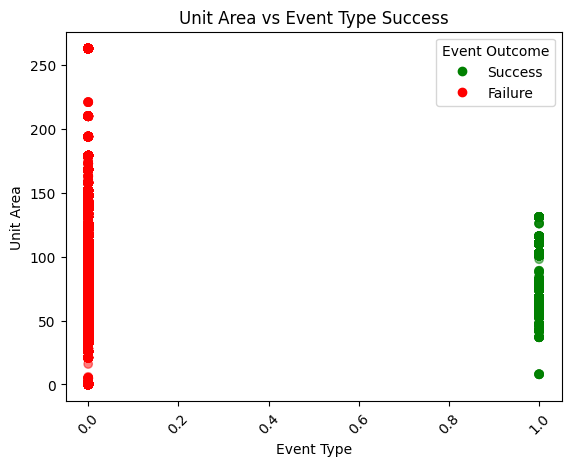

In [15]:
# Show area vs rental

# Define colors for success and failure
color_map = {1: 'green', 0: 'red'}

# Prepare the plot
fig, ax = plt.subplots()
#print(property_and_user_activity_encoded['event_type_num'])

# Create scatter plot
scatter = ax.scatter(
    property_and_user_activity_encoded['event_type_num'],  # Assuming this is the categorical description of events
    property_and_user_activity_encoded['unit_area'],
    c=property_and_user_activity_encoded['event_type_num'].map(color_map),  # Map 'event_type_num' to colors
    label=['Failure', 'Success'],  # Labels for the legend
    alpha=0.5
)

# Create a legend
legend_labels = {'Success': 'green', 'Failure': 'red'}
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in legend_labels.values()]
ax.legend(markers, legend_labels.keys(), title='Event Outcome')

ax.set_xlabel('Event Type')
ax.set_ylabel('Unit Area')
ax.set_title('Unit Area vs Event Type Success')
plt.xticks(rotation=45)
plt.show()



**DISPLAY RESULTS**

In [ ]:
print("-----STARTING-----")

# Update your dataset to include only the selected features

#selected_features = rfecv.get_support(1)
#X_reduced = df[df.columns[selected_features]]
#print(X)
#print(rfecv.support_)
#print(features)
#selected_features = np.array(features)[rfecv.support_]
#X_reduced = X[selected_features]
# Now split your reduced dataset into train and test sets
#train_set, test_set = train_test_split(pd.DataFrame(X_reduced, columns=np.array(features)[rfecv.support_]).join(y), test_size=0.2, random_state=42)

#train_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(train_set, label=target)
#test_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(test_set, label=target)

featureArr = [[], [], []]
#Tree #1: All Features
featureArr[0] = features

#Tree #2: Optimal Features
featureArr[1] = features[rfecv.support_]

#Tree #3: Highest Ranking Feature
feature_rankings = rfecv.ranking_
# Find the index of the best feature
best_feature_index = feature_rankings.argmin()
featureArr[2] = np.array([features[best_feature_index]])

print(featureArr)

## Split the data (80% for training, 20% for testing)
train_set, test_set = split_dataset(property_and_user_activity_encoded, 0.8)

for i in range(3):

  features = featureArr[i]

  # Only keep the features we want to study.
  select = np.concatenate((features, target))
  train_set_with_kept_features = train_set[select]
  test_set_with_kept_features = test_set[select]

  # Convert to TensorFlow datasets
  train_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(train_set_with_kept_features, label=target[0])
  test_tf_set = tfdf.keras.pd_dataframe_to_tf_dataset(test_set_with_kept_features, label=target[0])



  # Train the model
  dt_model = tfdf.keras.RandomForestModel(verbose=0, random_seed=1234)
  dt_model.fit(train_tf_set)

  # Evaluate accuracy
  dt_model.compile(metrics=["accuracy"])
  print(dt_model.evaluate(test_tf_set, return_dict=True, verbose=0))

  # Display results
  dt_viz = dtreeviz.model(dt_model, tree_index=0,
                             X_train=train_set[features.tolist()], y_train=train_set[target[0]],
                             feature_names=features.tolist(),
                             target_name=target[0])

  v = dt_viz.view()
  v.show()
  v.save(f"/content/drive/MyDrive/GT/ML Team Project/dt_{i}_viz.svg")

print("\n-----FINISHED-----")

-----STARTING-----
[array(['room_qty', 'unit_area', 'elevator', 'building_floor_count',
       'storage'], dtype='<U20'), array(['unit_area', 'elevator', 'building_floor_count', 'storage'],
      dtype='<U20'), array(['unit_area'], dtype='<U9')]
{'loss': 0.0, 'accuracy': 0.9928244948387146}


**EVALUATE ACCURACY IN DETAIL**

In [ ]:
print("-----STARTING-----")
# from Arian's version of this notebook
# Evaluate accuracy
dt_model.compile(metrics=['accuracy'])
results = dt_model.evaluate(test_tf_set, return_dict=True, verbose=0)
predictions = dt_model.predict(test_tf_set)
ground_truths = test_set_with_kept_features[target].values

# Get predicted values of y, and evaluate them.
y_pred = np.argmax(predictions, axis = 1)
precision = precision_score(ground_truths, y_pred, average='weighted')
recall = recall_score(ground_truths, y_pred, average='weighted')
f1 = f1_score(ground_truths, y_pred, average='weighted')

print("Accuracy:", results['accuracy'])
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\n-----FINISHED-----")